In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score
from xgboost import XGBRegressor
import sys 
sys.path.append('../../')
import laggedfeature

In [15]:
df = pd.read_csv('../../../Data/BNB-USD.csv', usecols=['Date', 'Close'])
df.dropna()
df.reset_index(drop=True)
df

,Date,Close
0,11/9/2017,1.990770
1,11/10/2017,1.796840
2,11/11/2017,1.670470
3,11/12/2017,1.519690
4,11/13/2017,1.686620
...,...,...
2039,6/10/2023,239.089081
2040,6/11/2023,235.438797
2041,6/12/2023,231.051437
2042,6/13/2023,243.890533


In [16]:
df['Date'] = pd.to_datetime(df['Date'])
df['MonthYear'] = df['Date'].dt.year.astype(str) +'-'+df['Date'].dt.month.astype(str)
df['MonthYear'] = df['MonthYear'].drop_duplicates()


In [17]:
# Create lagged feature
num_lags = 7
df['Lag'] = laggedfeature.set(num_lags, df['Close'])

In [18]:
# Train test val split in 6-2-2 set
test_size = int(len(df)*0.20)
val_size = int(len(df)*0.20)
train_size = int(len(df)-test_size-val_size)

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [19]:
model = XGBRegressor()
model.fit(train_data['Lag'], train_data['Close'])
model.score(test_data['Lag'], test_data['Close']) 

-3.185035880546476

In [20]:
y_test_pred = model.predict(test_data['Lag'])
y_val_pred = model.predict(val_data['Lag'])

In [21]:
# RMSE
rmse = mean_squared_error(test_data['Close'], y_test_pred, squared=False)
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))

The root mean squared error (RMSE) on test set: 203.138


In [22]:
#MAPE
mape = mean_absolute_percentage_error(test_data['Close'], y_test_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The mean absolute percentage error (MAPE) on test set: 0.377


In [23]:
# EVS 
evs = explained_variance_score(test_data['Close'], y_test_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))

The explained variance score (EVS) on test set: -0.004


In [24]:
# Predicting next 30 days' prices 
last_index=df.index[-1]

X_30 = laggedfeature.set_30(num_lags, df['Close'])
X_30.index = pd.RangeIndex(start=last_index+1, stop=last_index+31)
y_30_pred = model.predict(X_30)

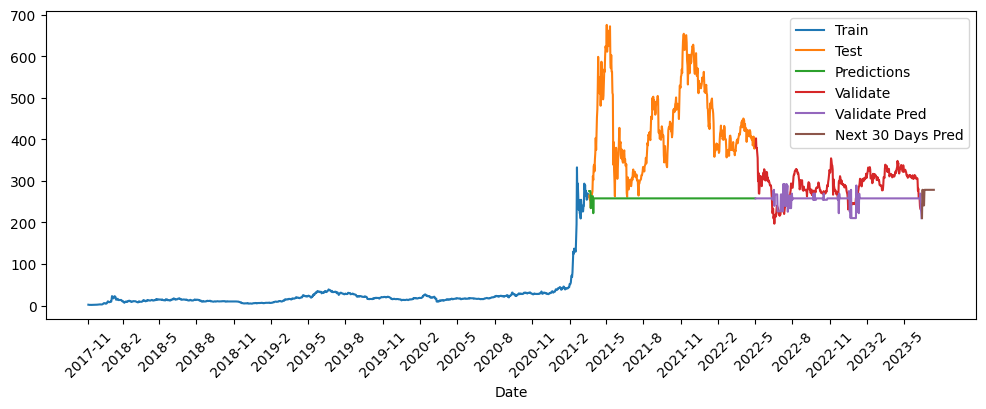

In [25]:
plt.subplots(figsize=(12, 4))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_test_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_val_pred)
plt.plot(X_30.index, y_30_pred)
plt.legend(['Train', 'Test', 'Predictions', 'Validate',
           'Validate Pred', 'Next 30 Days Pred'])

temp = df.dropna(subset=['MonthYear'])
temp = temp['MonthYear'].loc[::3]
plt.xticks(temp.index, temp, rotation=45)

plt.xlabel('Date')
plt.show()

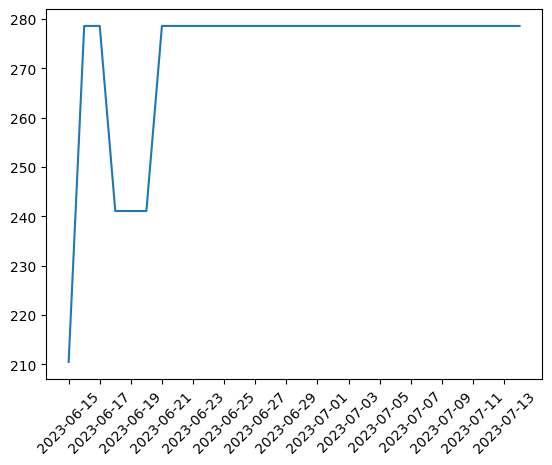

In [26]:
import datetime

last_day = df['Date'].iloc[-1]
next_days = np.array([])

for i in range(0, 30):
    last_day = last_day+datetime.timedelta(days=1)
    next_days = np.append(next_days, last_day)

plt.plot(next_days, y_30_pred)
plt.xticks(next_days[::2], rotation=45)
plt.show()